<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/04__Estimator_Flowers_transfer_learning_TFHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please select a GPU backend for this notebook. It uses pre-trained models from TF Hub which are not TPU-compatible yet

## Imports

In [0]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

W0417 00:32:35.936354 140198491186944 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Tensorflow version 1.13.1


## Colab-only auth
You would need this if you were accessing private GCS buckets. The training data for this exercise is in a public bucket for which authentication is not necessary.

In [0]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too
  
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
assert not HAS_COLAB_TPU, "Please select a GPU backend for this notebook. Pre-trained models in TF Hub are not yet TPU-compatible"

## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 6

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.list_files(GCS_PATTERN)
  dataset = dataset.with_options(option_no_order)
  #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

Instructions for updating:
Colocations handled automatically by placer.


W0417 00:32:37.218266 140198491186944 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/data/ops/iterator_ops.py:532: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


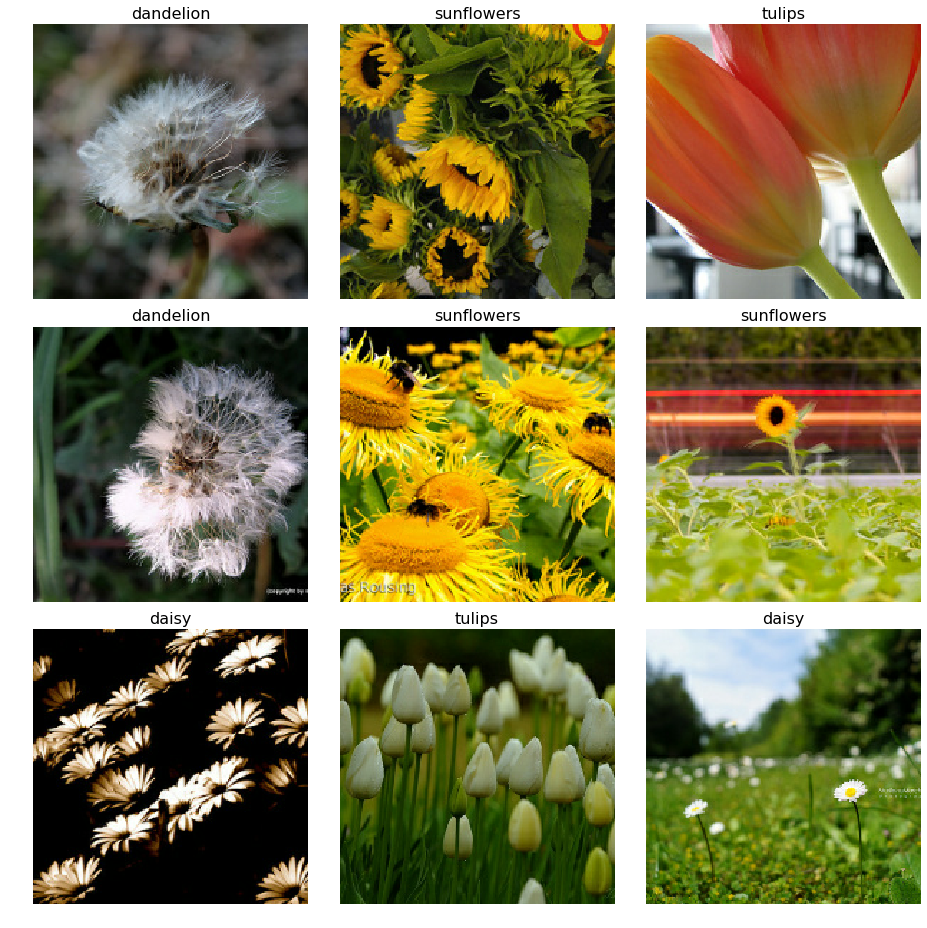

In [0]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [0]:
def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  #dataset = dataset.map(features_and_targets, num_parallel_calls=32)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
  return dataset

# input functions
def training_input_fn():
  return get_batched_dataset(training_filenames)
def validation_input_fn():
  return get_batched_dataset(validation_filenames)

## Model

In [0]:
def model_fn(features, labels, mode, params):
  module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_050_192/feature_vector/2")
  #module = hub.Module("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1")
  
  transformed_features = module(features)
  logits = tf.layers.dense(transformed_features, 5)
  probabilities = tf.nn.softmax(logits)
  
  if (mode != tf.estimator.ModeKeys.PREDICT):
    one_hot_labels = tf.one_hot(labels, len(CLASSES))
    loss = tf.losses.softmax_cross_entropy(one_hot_labels, logits)
    optimizer = tf.train.AdamOptimizer() 
    train_op = tf.contrib.training.create_train_op(loss, optimizer)
    accuracy = tf.metrics.accuracy(labels, tf.argmax(probabilities, axis=-1))
    metrics = {'acc':accuracy}
  else:
    # None of these can be computed in prediction mode because labels are not available
    loss = optimizer = train_op = metrics = None
  
  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=train_op,
      # Nice: in estimator, you can return computed results that are not part of model training (here: class)
      predictions={'proba': probabilities, 'class': tf.argmax(probabilities, axis=-1)},
      eval_metric_ops=metrics
  )

## Training

In [0]:
!rm -rf ./model_dir

In [0]:
training_config = tf.estimator.RunConfig(model_dir="./model_dir", save_summary_steps=5, save_checkpoints_steps=steps_per_epoch, log_step_count_steps=5)
estimator = tf.estimator.Estimator(model_fn=model_fn, config=training_config)
train_spec = tf.estimator.TrainSpec(training_input_fn, max_steps=EPOCHS*steps_per_epoch)
eval_spec = tf.estimator.EvalSpec(validation_input_fn, steps=validation_steps, throttle_secs=1)
result = tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [0]:
print(result)

({'loss': 0.18816751, 'global_step': 276, 'acc': 0.9390625}, [])


## Predictions

In [0]:
N=9
# random input: execute multiple times to change results
numpy_flowers, numpy_labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), N)

# tip: this is how to get create dataset from a numpy array
def predict_input_fn():
  return tf.data.Dataset.from_tensor_slices(numpy_flowers).batch(N)

predictions = estimator.predict(predict_input_fn)  # estimator.predict returns a Python generator
                                                   # you can iterate on it to get individual predictions

probabilities = []
for p in predictions:
  print(p['class'])  # as defined in EstimatorSpec.predictions
  print(p['proba'])
  probabilities.append(p['proba'])

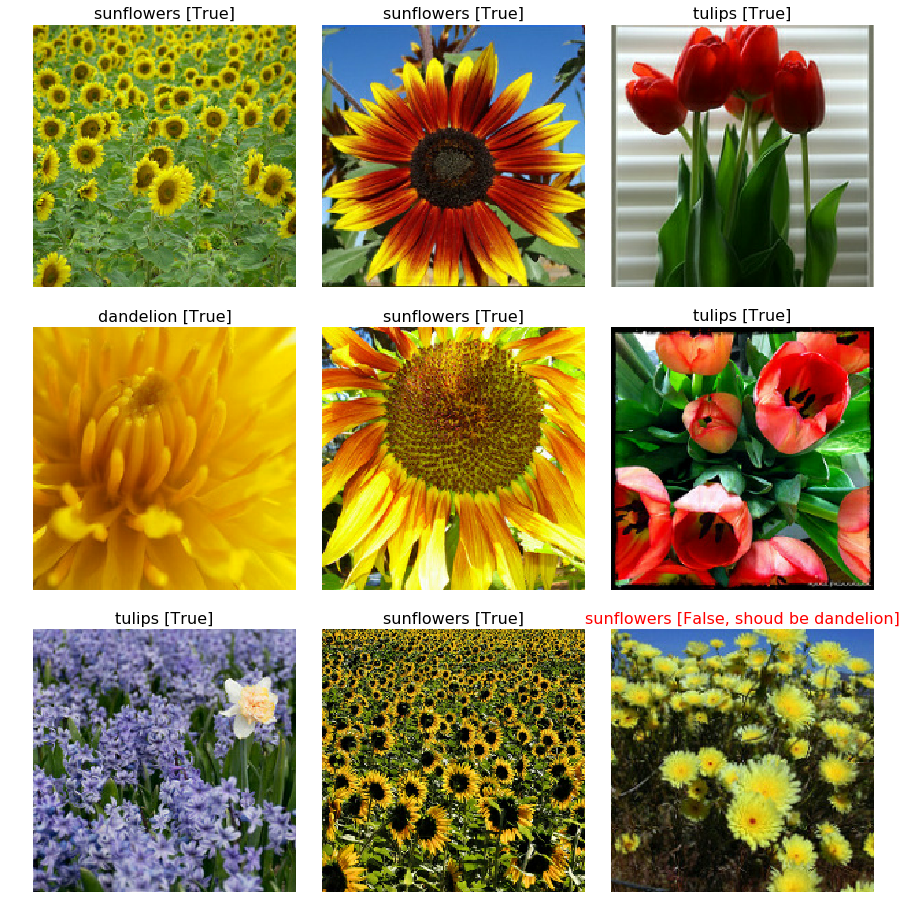

In [0]:
display_9_images_with_predictions(numpy_flowers, probabilities, numpy_labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
